In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR
from torch.utils.data import DataLoader

from swag import SWAG
from models import SimpleNet, ConvNN, Classification_relu, Classification_sigmoid, Classification_tanh
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights, plot_decision_boundary
from data_gen import ClassificationDataSet

torch.manual_seed(0)
np.random.seed(0)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Classification on a toy dataset

Since the paper proposed that the SWAG algorithm will be able to closely approximate the posterior of neural networks, we would like to apply this idea to a simple task of OOD detection. 

In the below section, we will apply SWAG to a really simple dataset borrowed from HW7 for OOD detection. Specifically, we have strategically selected a number of points to evaluate the model's ability to capture aleatoric and epistemic uncertainties. The expected behavior for the test points are described as the follows:
- `(-1, -1.5), (2, 1.5)`: in-distribution samples, should be classified corrected with high certainty
- `(-5, -5), (5, 5)`: OOD samples, should be assigned high uncertainty in prediction
- `(-5, 3.5), (5, -3.5)`: OOD samples, should be assigned high uncertainty in prediction. Note that these two points are roughly right on top of the linear decision boundary that separates the two classes, which means correctly assigning uncertainties is more challenging
- `(-1, 1), (1, -1)`: in-distribution samples, selected to evaluate the model's ability to capture aleatoric uncertainties since they lie on top of the two classes

In [2]:
# Create the training DataSet
train_data = ClassificationDataSet(n_samples=500, mode='train')
train_gen = DataLoader(dataset = train_data, batch_size = 8, shuffle = False)

X, y, X_test = train_data.X, train_data.Y.flatten(), train_data.test_points

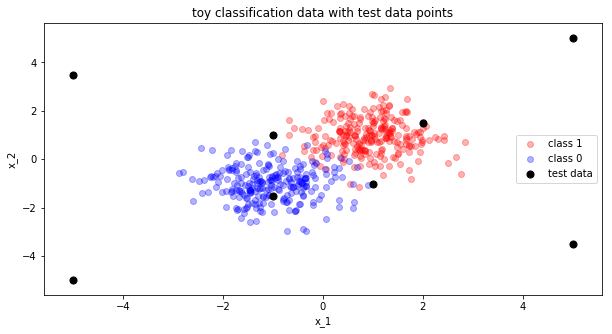

In [3]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(X_test)):
    pt = X_test[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

In [4]:
# Take a look at the architecture of Classification_NN
Classification_relu()

Classification_relu(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
)

In [5]:
# Initialize SWAG
swag = SWAG(Classification_relu, K = 10)
print("Total number of parameters for the NN is:", swag.weigt_D)

Total number of parameters for the NN is: 42


In [6]:
# Compile swag
objective = 'classification'
lr = 1e-2
momentum = 0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
train_scheduler = StepLR
swa_scheduler = LambdaLR

swag.compile(objective, lr, momentum, optimizer, loss_fn, train_scheduler, swa_scheduler)

In [7]:
# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=20,
                                    swag_epoch=20,
                                    log_freq=60)

Begin NN model training...
[Epoch: 1, 	Iteration:    60] 	Training Loss: 0.7274
[Epoch: 2, 	Iteration:    60] 	Training Loss: 0.4374
[Epoch: 3, 	Iteration:    60] 	Training Loss: 0.3677
[Epoch: 4, 	Iteration:    60] 	Training Loss: 0.3526
[Epoch: 5, 	Iteration:    60] 	Training Loss: 0.3496
[Epoch: 6, 	Iteration:    60] 	Training Loss: 0.3480
[Epoch: 7, 	Iteration:    60] 	Training Loss: 0.3471
[Epoch: 8, 	Iteration:    60] 	Training Loss: 0.3464
[Epoch: 9, 	Iteration:    60] 	Training Loss: 0.3460
[Epoch: 10, 	Iteration:    60] 	Training Loss: 0.3456
[Epoch: 11, 	Iteration:    60] 	Training Loss: 0.3453
[Epoch: 12, 	Iteration:    60] 	Training Loss: 0.3451
[Epoch: 13, 	Iteration:    60] 	Training Loss: 0.3449
[Epoch: 14, 	Iteration:    60] 	Training Loss: 0.3447
[Epoch: 15, 	Iteration:    60] 	Training Loss: 0.3446
[Epoch: 16, 	Iteration:    60] 	Training Loss: 0.3445
[Epoch: 17, 	Iteration:    60] 	Training Loss: 0.3443
[Epoch: 18, 	Iteration:    60] 	Training Loss: 0.3442
[Epoch: 19

## Uncertainty Measurement

One way to approximate the model uncertainty, is by measuring the variance (or standard deviation) of the model predictions for each point. We can repeatedly draw samples from the SWAG weights posterior to form a distribution over predictions for each point. The expected behavior is that, for the OOD points, the variance of predictions should be higher than for the in-sample points.

To assess the SWAG model, we wrote a function that perserves the predictions on all points using each sampled NN weights using the SWAG model, and then perform the uncertainty measurement.

In [8]:
# Sample 1000 posterior weights
expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=1000, expanded=True)
print("Shape of the expanded prediction:\n", expand_pred.shape)
print("Predictions for each point using the 1st sample weights:\n", expand_pred[0])

Shape of the expanded prediction:
 (1000, 8, 2)
Predictions for each point using the 1st sample weights:
 [[9.99976635e-01 2.33847186e-05]
 [2.32600055e-08 1.00000000e+00]
 [1.00000000e+00 3.60041214e-14]
 [1.91779175e-19 1.00000000e+00]
 [9.57620144e-01 4.23798040e-02]
 [3.68500859e-01 6.31499171e-01]
 [4.06007729e-02 9.59399223e-01]
 [9.11889076e-01 8.81108940e-02]]


In [9]:
xx = (-1, -1.5)
a = [swag.predict(torch.Tensor(xx).view(1, -1), [0, 1], S=1, expanded=False) for _ in range(100)]
np.std(a), np.mean(a)

(0.0, 0.0)

In [10]:
def uncertainty_measurement(X_test, expand_pred):
    ''' Params:
            X_test: test points
            expand_pred: swag prediction in expanded form
    '''
    var_list = []
    for i in range(len(X_test)):
        preds_i = np.argmax(expand_pred[:, i], axis=1)
        var_list.append(np.std(preds_i))

    for x,std in zip(X_test, var_list):
        print(f"Test point: {x} \tStandard Deviation in prediction: {std:.4f}")

uncertainty_measurement(X_test, expand_pred)

Test point: (-1, -1.5) 	Standard Deviation in prediction: 0.0000
Test point: (2, 1.5) 	Standard Deviation in prediction: 0.0000
Test point: (-5, -5) 	Standard Deviation in prediction: 0.0000
Test point: (5, 5) 	Standard Deviation in prediction: 0.0000
Test point: (-5, 3.5) 	Standard Deviation in prediction: 0.0447
Test point: (5, -3.5) 	Standard Deviation in prediction: 0.4621
Test point: (-1, 1) 	Standard Deviation in prediction: 0.0000
Test point: (1, -1) 	Standard Deviation in prediction: 0.2650


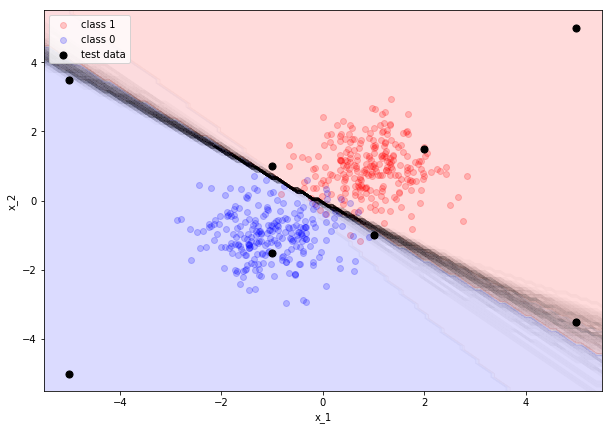

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_decision_boundary(swag, X, y, ax, poly_degree=1, test_points=X_test, shaded=True)

From the above uncertainty measurements, we see that the sampled weights from the posterior are too similar that the produced decision boundaries are almost identical. Additionally, the uncertainty measurement using std is positive only for the two data points that lie right on top of the decision boundary, while the 4 OOD points have no uncertainty whatsoever, which is undesirable.

To counter this problem, we will explore a number of possibilities
- use different activitation functions
- perform the pre-training for less epochs

In [12]:
# Try sigmoid activation
torch.manual_seed(0)
np.random.seed(0)

# Initialize SWAG
swag = SWAG(Classification_sigmoid, K = 10)
print("Total number of parameters for the NN is:", swag.weigt_D)

# Compile swag
objective = 'classification'
lr = 1e-1
momentum = 0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
train_scheduler = StepLR
swa_scheduler = LambdaLR

swag.compile(objective, lr, momentum, optimizer, loss_fn, train_scheduler, swa_scheduler)

# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=20,
                                    swag_epoch=20,
                                    log_freq=60,
                                    verbose=1)

# measure uncertainty
expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=1000, expanded=True)
uncertainty_measurement(X_test, expand_pred)

Total number of parameters for the NN is: 42
Begin NN model training...
[Epoch: 1, 	Iteration:    60] 	Training Loss: 0.8453
[Epoch: 2, 	Iteration:    60] 	Training Loss: 0.7917
[Epoch: 3, 	Iteration:    60] 	Training Loss: 0.7915
[Epoch: 4, 	Iteration:    60] 	Training Loss: 0.7912
[Epoch: 5, 	Iteration:    60] 	Training Loss: 0.7907
[Epoch: 6, 	Iteration:    60] 	Training Loss: 0.7897
[Epoch: 7, 	Iteration:    60] 	Training Loss: 0.7869
[Epoch: 8, 	Iteration:    60] 	Training Loss: 0.7748
[Epoch: 9, 	Iteration:    60] 	Training Loss: 0.8184
[Epoch: 10, 	Iteration:    60] 	Training Loss: 0.7439
[Epoch: 11, 	Iteration:    60] 	Training Loss: 0.9418
[Epoch: 12, 	Iteration:    60] 	Training Loss: 0.7576
[Epoch: 13, 	Iteration:    60] 	Training Loss: 0.5286
[Epoch: 14, 	Iteration:    60] 	Training Loss: 0.5499
[Epoch: 15, 	Iteration:    60] 	Training Loss: 0.3630
[Epoch: 16, 	Iteration:    60] 	Training Loss: 0.3488
[Epoch: 17, 	Iteration:    60] 	Training Loss: 0.3481
[Epoch: 18, 	Iterat

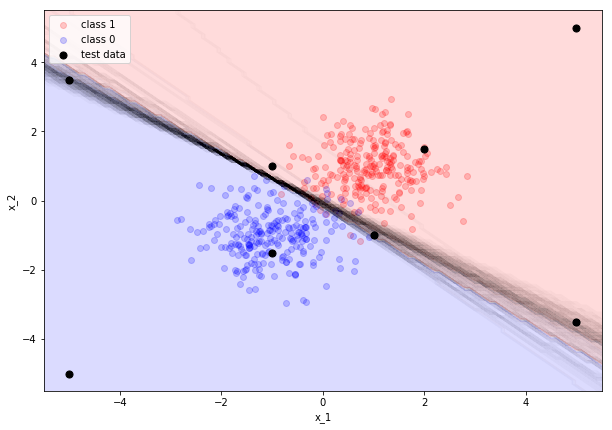

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_decision_boundary(swag, X, y, ax, poly_degree=1, test_points=X_test, shaded=True)

In [14]:
# Try tanh activation
torch.manual_seed(0)
np.random.seed(0)

# Initialize SWAG
swag = SWAG(Classification_tanh, K = 10)
print("Total number of parameters for the NN is:", swag.weigt_D)

# Compile swag
objective = 'classification'
lr = 1e-2
momentum = 0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
train_scheduler = StepLR
swa_scheduler = LambdaLR

swag.compile(objective, lr, momentum, optimizer, loss_fn, train_scheduler, swa_scheduler)

# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=20,
                                    swag_epoch=20,
                                    log_freq=60,
                                    verbose=1)

# measure uncertainty
expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=1000, expanded=True)
uncertainty_measurement(X_test, expand_pred)

Total number of parameters for the NN is: 42
Begin NN model training...
[Epoch: 1, 	Iteration:    60] 	Training Loss: 0.7495
[Epoch: 2, 	Iteration:    60] 	Training Loss: 0.4294
[Epoch: 3, 	Iteration:    60] 	Training Loss: 0.3677
[Epoch: 4, 	Iteration:    60] 	Training Loss: 0.3571
[Epoch: 5, 	Iteration:    60] 	Training Loss: 0.3529
[Epoch: 6, 	Iteration:    60] 	Training Loss: 0.3506
[Epoch: 7, 	Iteration:    60] 	Training Loss: 0.3492
[Epoch: 8, 	Iteration:    60] 	Training Loss: 0.3482
[Epoch: 9, 	Iteration:    60] 	Training Loss: 0.3475
[Epoch: 10, 	Iteration:    60] 	Training Loss: 0.3469
[Epoch: 11, 	Iteration:    60] 	Training Loss: 0.3464
[Epoch: 12, 	Iteration:    60] 	Training Loss: 0.3461
[Epoch: 13, 	Iteration:    60] 	Training Loss: 0.3458
[Epoch: 14, 	Iteration:    60] 	Training Loss: 0.3455
[Epoch: 15, 	Iteration:    60] 	Training Loss: 0.3453
[Epoch: 16, 	Iteration:    60] 	Training Loss: 0.3451
[Epoch: 17, 	Iteration:    60] 	Training Loss: 0.3449
[Epoch: 18, 	Iterat

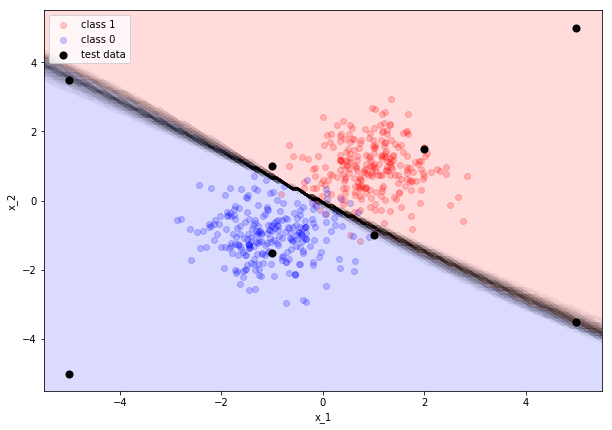

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_decision_boundary(swag, X, y, ax, poly_degree=1, test_points=X_test, shaded=True)